# LLM Energy Efficency Data Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy import integrate


In [17]:
# Load the data
devices = ['SRV', 'PC', 'RPI']
#devices = ['RPI']#, 'PC']
experiments = ['canonical', 'baseline', 'blanks', 'guideline', 'keyword', 'platform', 'few-shot', 'human']


def preprocess_data(df):
	# Remove all columns that start with 'CPU_FREQUENCY'
	frequency_columns = [column for column in df.columns if column.startswith('CPU_FREQUENCY')]
	df = df.drop(frequency_columns, axis=1)

	# Eliminate overflow error
	OVERFLOW_VALUE = 262143.328850
	overflow_counter = 0
	last_energy = -1
	for index, row in df.iterrows():
		if row['PACKAGE_ENERGY (J)'] < last_energy:
			overflow_counter += 1
		last_energy = row['PACKAGE_ENERGY (J)']
		df.loc[index, 'PACKAGE_ENERGY (J)'] = row['PACKAGE_ENERGY (J)'] + OVERFLOW_VALUE * overflow_counter

	# Calculate total energy usage
	total_energy = df['PACKAGE_ENERGY (J)'].iloc[-1] - df['PACKAGE_ENERGY (J)'].iloc[0]
	df['TOTAL_ENERGY'] = total_energy

	#if 'PP1_ENERGY (J)' in df.columns:
	#	df['TOTAL_ENERGY'] += df['PP1_ENERGY (J)']

	
	# Create max CPU usage column
	cpu_columns = [column for column in df.columns if column.startswith('CPU_USAGE')]
	df['MAX_CPU_USAGE'] = df[cpu_columns].max(axis=1)
	df['MAX_CPU_USAGE'] = df['MAX_CPU_USAGE'].fillna(-1)
	df = df.drop(cpu_columns, axis=1)

	# Create MEMORY usage column
	df['MEMORY_USAGE'] = df['USED_MEMORY'] / df['TOTAL_MEMORY'] * 100
	if df['USED_MEMORY'].max() == 0 and df['TOTAL_MEMORY'].max() == 0:
		df['MEMORY_USAGE'] = df['MEMORY_USAGE'].fillna(-1)
	elif df['USED_MEMORY'].max() == 0:
		df['MEMORY_USAGE'] = df['MEMORY_USAGE'].fillna(-2)
	elif df['TOTAL_MEMORY'].max() == 0:
		df['MEMORY_USAGE'] = df['MEMORY_USAGE'].fillna(-3)

	df = df.drop(['USED_MEMORY', 'TOTAL_MEMORY'], axis=1)

	# Create SWAP usage column
	df['SWAP_USAGE'] = df['USED_SWAP'] / df['TOTAL_SWAP'] * 100
	if df['USED_SWAP'].max() == 0 and df['TOTAL_SWAP'].max() == 0:
		df['SWAP_USAGE'] = df['SWAP_USAGE'].fillna(-1)
	elif df['USED_SWAP'].max() == 0:
		df['SWAP_USAGE'] = df['SWAP_USAGE'].fillna(-2)
	elif df['TOTAL_SWAP'].max() == 0:
		df['SWAP_USAGE'] = df['SWAP_USAGE'].fillna(-3)

	df = df.drop(['USED_SWAP', 'TOTAL_SWAP'], axis=1)

	# Reset time to start from 0
	if df['Time'][1] - df['Time'][0] < df['Delta'][1]:
		df.at[0, 'Time'] = df['Time'][1] - df['Delta'][1]
		df = df.reset_index(drop=True)
	df['Time'] = df['Time'] - df['Time'][0]

	# Convert time to seconds
	df['Time'] = df['Time'] / 1000

	# Remove delta column
	df = df.drop('Delta', axis=1)

	return df, total_energy


def replace_old_llms(df):
	df['llm'] = df['llm'].replace('chatgpt_temp_0.0', 'chatgpt')
	df['llm'] = df['llm'].replace('gpt-4_temp_0.0', 'gpt-4')
	df['llm'] = df['llm'].replace('deepseek-coder-33b-instruct_temp_0.0', 'deepseek-coder')
	df['llm'] = df['llm'].replace('code-millenials-34b_temp_0.0', 'code-millenials')
	df['llm'] = df['llm'].replace('speechless-codellama-34b_temp_0.0', 'speechless-codellama')
	df['llm'] = df['llm'].replace('wizardcoder-33b-1.1_temp_0.0', 'wizardcoder')
	return df


def load_data(device, experiment):
	results_path = f'../{device}/{experiment}/results/'
	parallels = os.listdir(results_path)
	
	nollm_flag = False
	
	df = pd.DataFrame()
	meta = pd.DataFrame()
	for parallel in parallels:
		path = os.path.join(results_path, parallel)
		print(f'Loading {path}/run_table.csv')
		with open(f'{path}/run_table.csv') as f:
			first_line = f.readline().strip('\n')
		if 'llm' in first_line:
			meta_df = pd.read_csv(os.path.join(path, 'run_table.csv'), sep=',', usecols=['__run_id','llm','code'])
			if meta_df['llm'].isnull().all():
				nollm_flag = True
		else:
			meta_df = pd.read_csv(os.path.join(path, 'run_table.csv'), sep=',', usecols=['__run_id','code'])
			meta_df['llm'] = 'no_llm'
			nollm_flag = True
			

		meta_df = replace_old_llms(meta_df)
		meta_df['TOTAL_ENERGY'] = 0.0
		for index, row in meta_df.iterrows():
			run = row['__run_id']

			# Load the data
			if device != 'RPI':
				try:
					tmp = pd.read_csv(os.path.join(path, f'{run}/energibridge.csv'))
				except:
					print(f'Error loading {path}/{run}/energibridge.csv')
					continue
				tmp, energy = preprocess_data(tmp)
			else:
				try:
					tmp = pd.read_csv(os.path.join(path, f'{run}/monsoon_fixed.csv'), nrows=3)
				except:
					print(f'Error loading {path}/{run}/monsoon_fixed.csv')
					continue
				energy = tmp.loc[1, 'TOTAL_ENERGY']
	
			tmp['repetition'] = run.split('_')[-1]
			meta_df.loc[index, 'TOTAL_ENERGY'] = energy
			tmp['code'] = row['code']

			if nollm_flag:
				for llm in ['chatgpt','gpt-4', 'deepseek-coder', 'code-millenials', 'speechless-codellama', 'wizardcoder']:
					tmp['llm'] = llm
					df = pd.concat([df, tmp])
			else:
				tmp['llm'] = row['llm']
				df = pd.concat([df, tmp])

		meta = pd.concat([meta, meta_df])

	df['device'] = device
	meta['device'] = device
	df['experiment'] = experiment
	meta['experiment'] = experiment
	if experiment == 'human':
		df['experiment'] = 'expert'
		meta['experiment'] = 'expert'
	elif experiment == 'canonical':
		df['experiment'] = 'developer'
		meta['experiment'] = 'developer'

	return df, meta


for device in devices:
	data_df = pd.DataFrame()
	metadata_df = pd.DataFrame()
	for experiment in experiments:
		df, meta = load_data(device, experiment)
		data_df = pd.concat([data_df, df])
		metadata_df = pd.concat([metadata_df, meta])
	data_df.to_parquet(f'../{device}/data_df.parquet')
	metadata_df.to_parquet(f'../{device}/metadata_df.parquet')


Loading ../SRV/canonical/results/1/run_table.csv
Loading ../SRV/baseline/results/1/run_table.csv
Loading ../SRV/baseline/results/2/run_table.csv
Loading ../SRV/blanks/results/1/run_table.csv
Loading ../SRV/blanks/results/2/run_table.csv
Loading ../SRV/guideline/results/1/run_table.csv
Loading ../SRV/guideline/results/2/run_table.csv
Loading ../SRV/keyword/results/1/run_table.csv
Loading ../SRV/keyword/results/2/run_table.csv
Loading ../SRV/platform/results/1/run_table.csv
Loading ../SRV/platform/results/2/run_table.csv
Loading ../SRV/few-shot/results/1/run_table.csv
Loading ../SRV/few-shot/results/2/run_table.csv
Loading ../SRV/human/results/1/run_table.csv
Loading ../PC/canonical/results/1/run_table.csv
Loading ../PC/baseline/results/1/run_table.csv
Loading ../PC/baseline/results/2/run_table.csv
Loading ../PC/blanks/results/1/run_table.csv
Loading ../PC/blanks/results/2/run_table.csv
Loading ../PC/guideline/results/1/run_table.csv
Loading ../PC/guideline/results/2/run_table.csv
Loadin

In [90]:
data_df = pd.read_parquet('../RPI/data_df.parquet')
metadata_df = pd.read_parquet('../RPI/metadata_df.parquet')

In [3]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


plt.rcParams['font.family'] = 'Arial'
custom_params = {"axes.spines.right": False, 
								 "axes.spines.top": False,
								 "axes.spines.left": True,
								 "axes.spines.bottom": True,
								 "xtick.bottom": True,
								 "ytick.left": True,
								 "axes.edgecolor": "black",
								 "axes.grid": True,
								 "axes.linewidth": 1.5, 
								 "axes.facecolor": "white", 
								 "grid.color": "lightgray"}

custom_mean = {"marker":"d",
								"markerfacecolor":"white", 
								"markeredgecolor":"black",
								"markersize":"7"}

custom_outliers = {'marker': 'o', 
									 'markerfacecolor': 'grey'}

sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.7)

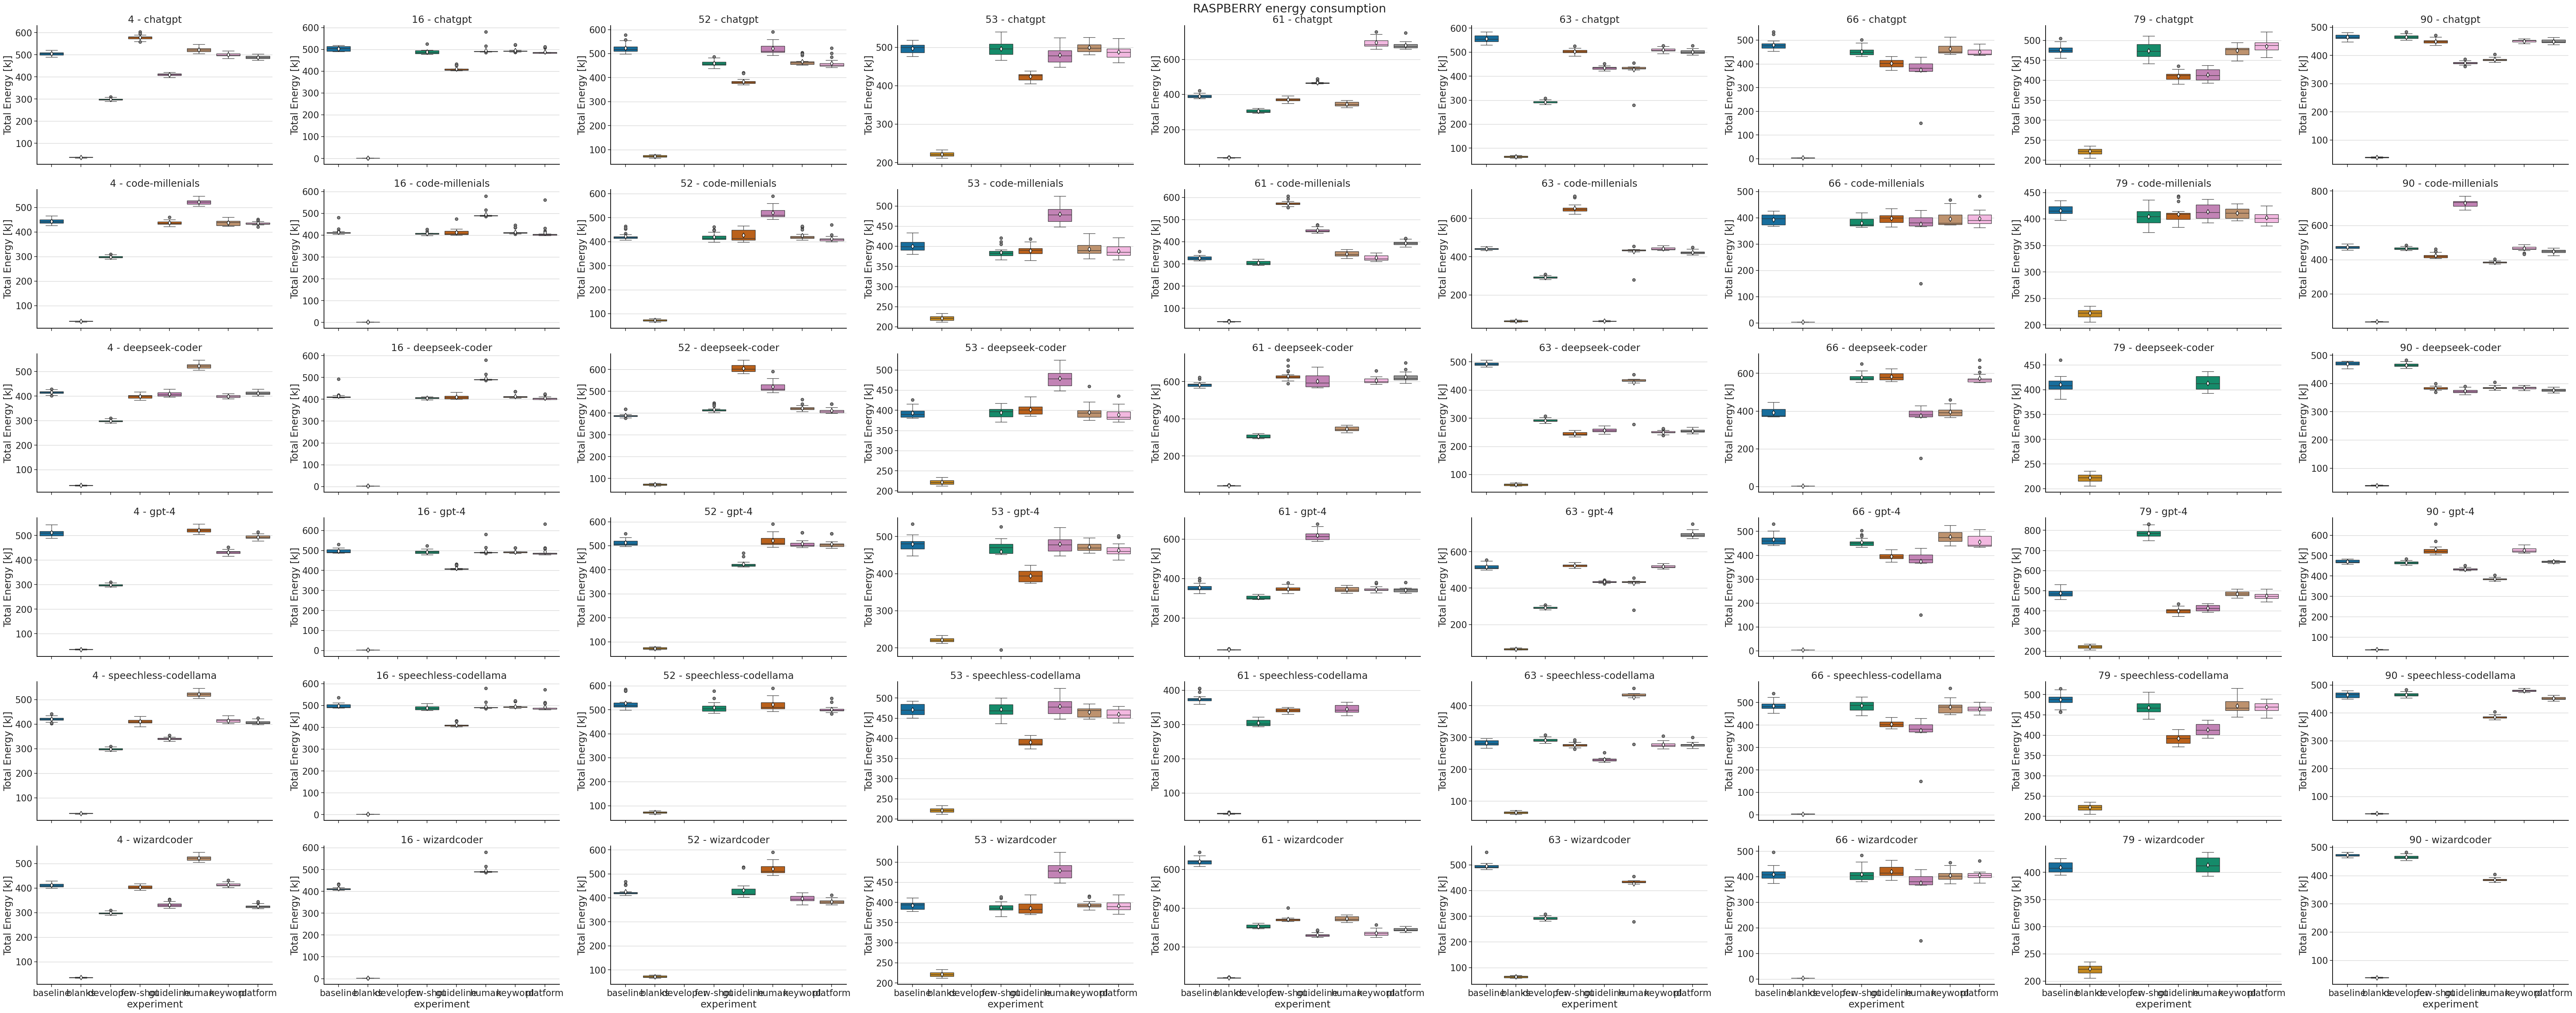

In [92]:
# disable warnings
import warnings
warnings.filterwarnings("ignore")

# calculate the total energy consumption per experiment per llm per code per repetition
#energy_df = data_df.groupby(['device', 'experiment', 'llm', 'code', 'repetition'])['TOTAL_ENERGY'].reset_index()
data_df['Total Energy [kJ]'] = data_df['TOTAL_ENERGY'] / 1000.0
plotter = data_df.groupby(['device', 'experiment', 'llm', 'code', 'repetition'])['Total Energy [kJ]'].mean().reset_index()

def big_boxplot(data, x, y, device):
	fig, axs = plt.subplots(nrows=6, ncols=9, figsize=(75, 30), sharey=False, sharex=True)
	for code_index, code in enumerate(data['code'].unique()):
		for llm_index, llm in enumerate(data['llm'].unique()):
			to_plot = data[data['code'] == code]
			to_plot = to_plot[to_plot['llm'] == llm]
			to_plot = to_plot.reset_index(drop=True)
			
			sns.boxplot(x=x, y=y, data=to_plot, showmeans=True, meanprops=custom_mean, palette="colorblind", flierprops=custom_outliers, ax=axs[llm_index, code_index])
			axs[llm_index, code_index].set_title(f'{code} - {llm}')
	plt.suptitle(device + ' energy consumption')
	plt.tight_layout()
	plt.savefig(f'./figures/{device}_energy_consumption.pdf', format='pdf')
	plt.show()

#big_boxplot(plotter[plotter['device'] == 'SRV'], 'experiment', 'Total Energy [kJ]', 'SERVER')
#big_boxplot(plotter[plotter['device'] == 'PC'], 'experiment', 'Total Energy [kJ]', 'PC')
big_boxplot(plotter[plotter['device'] == 'RPI'], 'experiment', 'Total Energy [kJ]', 'RASPBERRY')

# Server

## Statistics

In [8]:
import scipy
import scipy.stats
import numpy as np
import pandas as pd
from cliffs_delta import cliffs_delta

device = 'SRV'
experiments = ['blanks', 'baseline', 'keyword', 'platform', 'guideline', 'few-shot', 'developer', 'expert']

data_df = pd.read_parquet(f'../{device}/data_df.parquet')
data_df = data_df.reset_index()
data_df = data_df.dropna()
data_df = data_df.drop(columns=['index'])
data_df['Total Energy [kJ]'] = data_df['TOTAL_ENERGY'] / 1000.0
data_df = data_df.drop(data_df[(data_df['experiment'].isin(['blanks', 'developer', 'expert'])) & (data_df['llm'] != 'chatgpt')].index)
plotter = data_df.groupby(['device', 'experiment', 'llm', 'code', 'repetition'])['Total Energy [kJ]'].mean().reset_index()
plotter.to_parquet(f'../{device}/r_ready.parquet')


summary = plotter[['experiment', 'Total Energy [kJ]']].groupby(['experiment'])
print(summary.describe().reset_index().T.to_latex())
# print(summary.describe().to_latex())

\begin{tabular}{llllllllll}
\toprule
 &  & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 \\
\midrule
experiment &  & baseline & blanks & developer & expert & few-shot & guideline & keyword & platform \\
\cline{1-10}
\multirow[t]{8}{*}{Total Energy [kJ]} & count & 1134.000000 & 189.000000 & 189.000000 & 84.000000 & 966.000000 & 945.000000 & 1008.000000 & 1008.000000 \\
 & mean & 6.058222 & 0.990792 & 5.096818 & 4.006479 & 6.859861 & 7.751075 & 6.232702 & 6.117685 \\
 & std & 1.400085 & 1.198575 & 0.702806 & 0.846431 & 7.383730 & 10.597318 & 2.729991 & 1.514002 \\
 & min & 2.595611 & 0.003634 & 3.355261 & 2.532357 & 2.472236 & 0.643832 & 2.587379 & 2.484835 \\
 & 25% & 5.187650 & 0.239756 & 4.678888 & 3.195180 & 4.670911 & 5.004775 & 5.020339 & 5.209832 \\
 & 50% & 5.767377 & 0.605415 & 5.095484 & 3.845944 & 5.409622 & 5.834342 & 5.814112 & 5.874745 \\
 & 75% & 6.770720 & 0.886347 & 5.562170 & 4.497562 & 6.267283 & 6.798297 & 6.750195 & 6.739866 \\
 & max & 11.301024 & 4.794539 & 7.293618 & 5.591173 & 5

In [9]:
summary_reset = summary.describe().reset_index()
summary_reset['coef_var'] = summary_reset['Total Energy [kJ]']['std'] / summary_reset['Total Energy [kJ]']['mean'] * 100.0
summary_reset['coef_var'] = summary_reset['coef_var'].round(3)
summary_reset

experiment Total Energy [kJ]                                           \
                         count      mean        std       min       25%   
0   baseline            1134.0  6.058222   1.400085  2.595611  5.187650   
1     blanks             189.0  0.990792   1.198575  0.003634  0.239756   
2  developer             189.0  5.096818   0.702806  3.355261  4.678888   
3     expert              84.0  4.006479   0.846431  2.532357  3.195180   
4   few-shot             966.0  6.859861   7.383730  2.472236  4.670911   
5  guideline             945.0  7.751075  10.597318  0.643832  5.004775   
6    keyword            1008.0  6.232702   2.729991  2.587379  5.020339   
7   platform            1008.0  6.117685   1.514002  2.484835  5.209832   

                                 coef_var  
        50%       75%        max           
0  5.767377  6.770720  11.301024   23.110  
1  0.605415  0.886347   4.794539  120.971  
2  5.095484  5.562170   7.293618   13.789  
3  3.845944  4.497562   5.591173   21.127  
4  5.409622  6.267283  53.096098  107.637  
5  5.834342  6.798297  75.168478  136.721  
6  5.814112  6.750195  24.436099   43.801  
7  5.874745  6.739866  12.058765   24.748

#### Percentages

In [10]:
# give me the differences between the groups means in percentages
for experiment in experiments:
	for experiment2 in experiments:
		if experiment == experiment2:
			continue
		group_1 = plotter[plotter['experiment'] == experiment]['Total Energy [kJ]']
		group_2 = plotter[plotter['experiment'] == experiment2]['Total Energy [kJ]']
		print(experiment, experiment2, (group_1.mean() - group_2.mean()) / group_2.mean() * 100.0, '%')
	print()

blanks baseline -83.64549334851202 %
blanks keyword -84.10332572747048 %
blanks platform -83.8044579650145 %
blanks guideline -87.21735620040704 %
blanks few-shot -85.55667092812118 %
blanks developer -80.56057306236777 %
blanks expert -75.2702508079878 %
baseline blanks 511.4522567447899 %
baseline keyword -2.799426413249803 %
baseline platform -0.9719927350301435 %
baseline guideline -21.840236015740867 %
baseline few-shot -11.685938440920648 %
baseline developer 18.862814708406898 %
baseline expert 51.2106095218851 %
keyword blanks 529.0623956031258 %
keyword baseline 2.880051330922808 %
keyword platform 1.8800647061909561 %
keyword guideline -19.589194692866087 %
keyword few-shot -9.142448135596396 %
keyword developer 22.286124785388683 %
keyword expert 55.56555269391664 %
platform blanks 517.4538634395857 %
platform baseline 0.981533166096513 %
platform keyword -1.8453705458598029 %
platform guideline -21.073072009692606 %
platform few-shot -10.819106636391393 %
platform developer

blanks
Stat: 0.7458340451215367, P-value: 9.536410481829874e-17

baseline
Stat: 0.9349851084600695, P-value: 7.965122512030517e-22

keyword
Stat: 0.5680194651154971, P-value: 2.798328686565401e-44

platform
Stat: 0.940538520126097, P-value: 1.1662541560517162e-19

guideline
Stat: 0.2891085205395698, P-value: 6.939450355468654e-51

few-shot
Stat: 0.32562737369802386, P-value: 1.9063222530477948e-50

developer
Stat: 0.9895576652297448, P-value: 0.18293702605405976

expert
Stat: 0.9466778149329373, P-value: 0.0016474439020685498



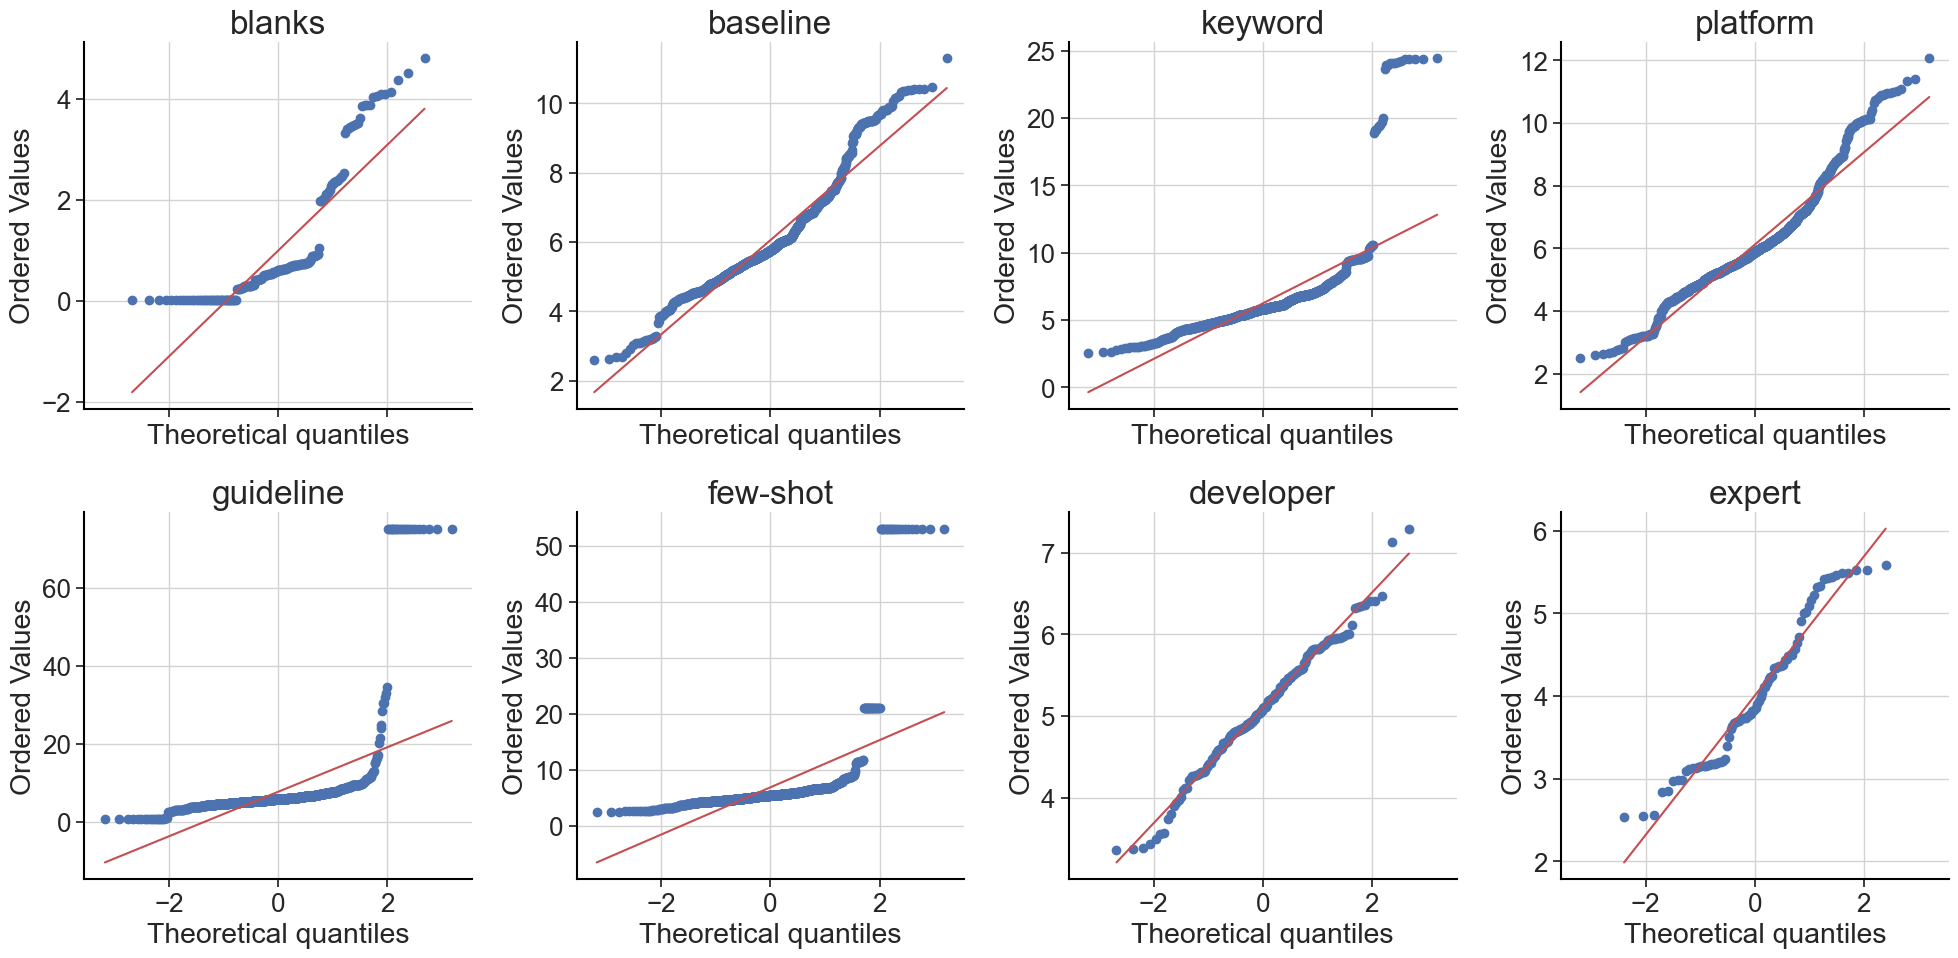

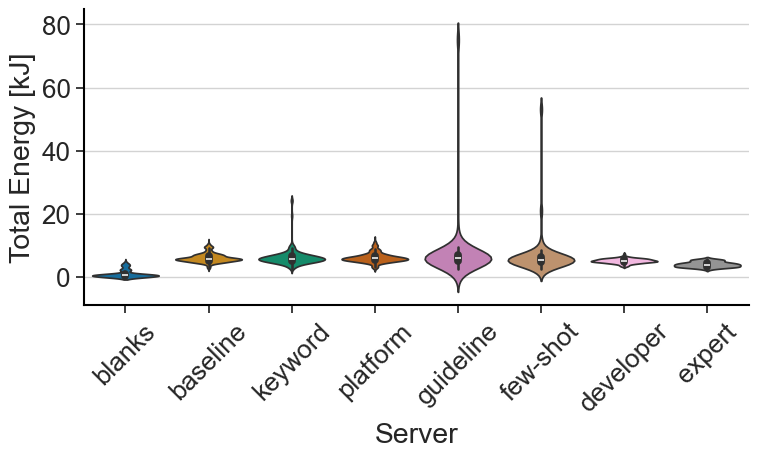

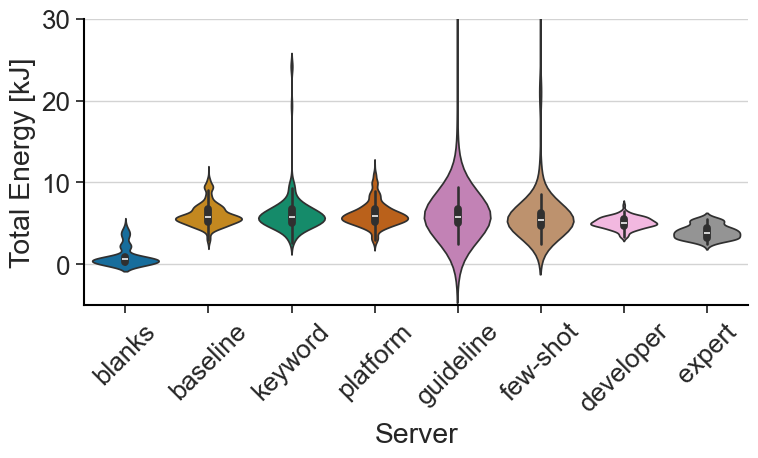

In [11]:
import scipy.stats as stats
import pylab as py

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10), sharey=False, sharex=True)

for id, experiment in enumerate(experiments):
	data_group = plotter[plotter['experiment'] == experiment]['Total Energy [kJ]']
	if experiment in ['blanks', 'developer', 'expert']:
		data_group = plotter[(plotter['experiment'] == experiment) & (plotter['llm'] == 'chatgpt')]['Total Energy [kJ]']
	
	res = scipy.stats.shapiro(data_group)
	print(experiment)
	print(f'Stat: {res.statistic}, P-value: {res.pvalue}')
	stats.probplot(data_group, dist='norm', plot=axs[id//4][id%4])
	axs[id//4][id%4].set_title(f'{experiment}', fontsize=24)
	print()
plt.tight_layout()
plt.savefig(f'./figures/{device}_QQ_plots.pdf', format='pdf')

plt.show()


fig, ax = plt.subplots(1, 1, figsize=(8, 5))
# sns.boxplot(x='experiment', y='Total Energy [kJ]', data=plotter, order=experiments, \
						# showmeans=True, meanprops=custom_mean, flierprops=custom_outliers, \
						# palette="colorblind", ax=ax)
sns.violinplot(x='experiment', y='Total Energy [kJ]', data=plotter, ax=ax, palette="colorblind", order=experiments)
ax.tick_params(axis='x', labelrotation=45)
plt.xlabel(f'Server')
plt.tight_layout()
plt.savefig(f'./figures/{device}_exploration.pdf', format='pdf')

plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
# sns.boxplot(x='experiment', y='Total Energy [kJ]', data=plotter, order=experiments, \
						# showmeans=True, meanprops=custom_mean, flierprops=custom_outliers, \
						# palette="colorblind", ax=ax)
sns.violinplot(x='experiment', y='Total Energy [kJ]', data=plotter, ax=ax, palette="colorblind", order=experiments)
ax.tick_params(axis='x', labelrotation=45)
ax.set_ylim(-5, 30)
plt.xlabel(f'Server')
plt.tight_layout()
# plt.savefig(f'./figures/{device}_exploration.pdf', format='pdf')

plt.show()

### RQ1

In [12]:
group_1 = plotter[(plotter['experiment'] == 'developer') & (plotter['llm'] == 'chatgpt')]['Total Energy [kJ]']
group_2 = plotter[plotter['experiment'] == 'baseline']['Total Energy [kJ]']

# A positive value means the first group has higher ranks, while a negative value suggests the opposite.
print(cliffs_delta(group_1, group_2))

(-0.4568927708257514, 'medium')


### RQ2

In [13]:
group_1 = plotter[plotter['experiment'] == 'keyword']['Total Energy [kJ]']
group_2 = plotter[plotter['experiment'] == 'guideline']['Total Energy [kJ]']
group_3 = plotter[plotter['experiment'] == 'platform']['Total Energy [kJ]']
group_4 = plotter[plotter['experiment'] == 'few-shot']['Total Energy [kJ]']
group_5 = plotter[plotter['experiment'] == 'baseline']['Total Energy [kJ]']


# A positive value means the first group has higher ranks, while a negative value suggests the opposite.
print('baseline vs. keyword:', cliffs_delta(group_5, group_1)) 
print('baseline vs. guideline:', cliffs_delta(group_5, group_2)) 
print('baseline vs. platform:', cliffs_delta(group_5, group_3)) 
print('baseline vs. few-shot:', cliffs_delta(group_5, group_4)) 
print('keyword vs. guideline:', cliffs_delta(group_1, group_2)) 
print('keyword vs. platform:', cliffs_delta(group_1, group_3)) 
print('keyword vs. few-shot:', cliffs_delta(group_1, group_4)) 
print('guideline vs. platform:', cliffs_delta(group_2, group_3)) 
print('guideline vs. few-shot:', cliffs_delta(group_2, group_4)) 
print('platform vs. few-shot:', cliffs_delta(group_3, group_4))

baseline vs. keyword: (0.02833942218862854, 'negligible')
baseline vs. guideline: (0.005641872661273014, 'negligible')
baseline vs. platform: (-0.02905853699504493, 'negligible')
baseline vs. few-shot: (0.21048816735497206, 'small')
keyword vs. guideline: (-0.02077769379356681, 'negligible')
keyword vs. platform: (-0.0552996661627614, 'negligible')
keyword vs. few-shot: (0.17424783923231127, 'small')
guideline vs. platform: (-0.029799697656840513, 'negligible')
guideline vs. few-shot: (0.1777931140249981, 'small')
platform vs. few-shot: (0.22611447960826841, 'small')


In [14]:
generated_names = ['baseline', 'keyword', 'platform', 'guideline', 'few-shot']
llm_ranking = plotter[plotter['experiment'].isin(generated_names)]

for name in generated_names:
	print(name, llm_ranking[llm_ranking['experiment'] == name].groupby(['llm'])['Total Energy [kJ]'].mean().reset_index().sort_values(by='Total Energy [kJ]'))
	print()

print('overall', llm_ranking.groupby(['llm'])['Total Energy [kJ]'].mean().reset_index().sort_values(by='Total Energy [kJ]'))


baseline                     llm  Total Energy [kJ]
4  speechless-codellama           4.998782
3                 gpt-4           5.343690
0               chatgpt           5.518757
1       code-millenials           6.472982
5           wizardcoder           6.979638
2        deepseek-coder           7.035482

keyword                     llm  Total Energy [kJ]
4  speechless-codellama           5.097218
3                 gpt-4           5.432325
0               chatgpt           5.870148
2        deepseek-coder           6.406326
1       code-millenials           6.592070
5           wizardcoder           8.531276

platform                     llm  Total Energy [kJ]
4  speechless-codellama           5.047304
0               chatgpt           5.811824
3                 gpt-4           5.868618
5           wizardcoder           6.430588
2        deepseek-coder           6.764810
1       code-millenials           6.875008

guideline                     llm  Total Energy [kJ]
4  speechless-c

### RQ3

In [15]:
group_7 = plotter[(plotter['experiment'] == 'expert') & (plotter['llm'] == 'chatgpt')]['Total Energy [kJ]']
group_all = plotter[(~plotter['experiment'].isin(['developer', 'expert'])) & (plotter['code'].isin([4, 61, 63, 90]))]
group_all = pd.concat([group_all, plotter[(plotter['experiment'] == 'developer') & (plotter['llm'] == 'chatgpt')]])
group_all = group_all['Total Energy [kJ]']


group_1 = plotter[(plotter['experiment'] == 'keyword') & (plotter['code'].isin([4, 61, 63, 90]))]['Total Energy [kJ]']
group_2 = plotter[(plotter['experiment'] == 'guideline') & (plotter['code'].isin([4, 61, 63, 90]))]['Total Energy [kJ]']
group_3 = plotter[(plotter['experiment'] == 'platform') & (plotter['code'].isin([4, 61, 63, 90]))]['Total Energy [kJ]']
group_4 = plotter[(plotter['experiment'] == 'few-shot') & (plotter['code'].isin([4, 61, 63, 90]))]['Total Energy [kJ]']
group_5 = plotter[(plotter['experiment'] == 'baseline') & (plotter['code'].isin([4, 61, 63, 90]))]['Total Energy [kJ]']
group_6 = plotter[(plotter['experiment'] == 'developer') & (plotter['llm'] == 'chatgpt') & (plotter['code'].isin([4, 61, 63, 90]))]['Total Energy [kJ]']

# A positive value means the first group has higher ranks, while a negative value suggests the opposite.
print('expert vs. keyword:', cliffs_delta(group_7, group_1))
print('expert vs. guideline:', cliffs_delta(group_7, group_2))
print('expert vs. platform:', cliffs_delta(group_7, group_3))
print('expert vs. few-shot:', cliffs_delta(group_7, group_4))
print('expert vs. baseline:', cliffs_delta(group_7, group_5))
print('expert vs. developer:', cliffs_delta(group_7, group_6))

expert vs. keyword: (-0.6981034838177695, 'large')
expert vs. guideline: (-0.6143334526793174, 'large')
expert vs. platform: (-0.747273512579635, 'large')
expert vs. few-shot: (-0.5964852607709751, 'large')
expert vs. baseline: (-0.7729119425547997, 'large')
expert vs. developer: (-0.6062925170068028, 'large')


# PC

## Statistics

In [32]:
import scipy
import scipy.stats
import numpy as np
import pandas as pd
from cliffs_delta import cliffs_delta

device = 'PC'
experiments = ['blanks', 'baseline', 'keyword', 'platform', 'guideline', 'few-shot', 'developer', 'expert']

data_df = pd.read_parquet(f'../{device}/data_df.parquet')
data_df = data_df.reset_index()
data_df = data_df.dropna()
data_df = data_df.drop(columns=['index'])
data_df['Total Energy [kJ]'] = data_df['TOTAL_ENERGY'] / 1000.0
data_df = data_df.drop(data_df[(data_df['experiment'].isin(['blanks', 'developer', 'expert'])) & (data_df['llm'] != 'chatgpt')].index)
plotter = data_df.groupby(['device', 'experiment', 'llm', 'code', 'repetition'])['Total Energy [kJ]'].mean().reset_index()
plotter.to_parquet(f'../{device}/r_ready.parquet')


summary = plotter[['experiment', 'Total Energy [kJ]']].groupby(['experiment'])
print(summary.describe().reset_index().T.to_latex())
# print(summary.describe().to_latex())

\begin{tabular}{llllllllll}
\toprule
 &  & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 \\
\midrule
experiment &  & baseline & blanks & developer & expert & few-shot & guideline & keyword & platform \\
\cline{1-10}
\multirow[t]{8}{*}{Total Energy [kJ]} & count & 1134.000000 & 189.000000 & 189.000000 & 84.000000 & 1008.000000 & 945.000000 & 1008.000000 & 1008.000000 \\
 & mean & 8.619750 & 1.435157 & 11.462073 & 5.989170 & 12.828610 & 12.979231 & 8.773374 & 8.605537 \\
 & std & 1.619199 & 1.662806 & 2.305505 & 1.238324 & 23.517707 & 28.393784 & 3.236581 & 1.799863 \\
 & min & 4.092799 & 0.001365 & 6.415537 & 4.518149 & 0.001185 & 0.881188 & 3.855062 & 3.849704 \\
 & 25% & 7.369788 & 0.483469 & 9.437310 & 4.878820 & 7.133516 & 8.194393 & 7.677071 & 7.752199 \\
 & 50% & 8.718602 & 0.715897 & 12.408076 & 6.066521 & 8.834660 & 9.073345 & 8.584498 & 8.851912 \\
 & 75% & 9.755188 & 1.314723 & 13.051010 & 7.327404 & 9.812566 & 9.927154 & 9.628211 & 9.773155 \\
 & max & 12.600948 & 4.892182 & 16.114481 & 8.21

In [33]:
summary_reset = summary.describe().reset_index()
summary_reset['coef_var'] = summary_reset['Total Energy [kJ]']['std'] / summary_reset['Total Energy [kJ]']['mean'] * 100.0
summary_reset['coef_var'] = summary_reset['coef_var'].round(3)
summary_reset

experiment Total Energy [kJ]                                            \
                         count       mean        std       min       25%   
0   baseline            1134.0   8.619750   1.619199  4.092799  7.369788   
1     blanks             189.0   1.435157   1.662806  0.001365  0.483469   
2  developer             189.0  11.462073   2.305505  6.415537  9.437310   
3     expert              84.0   5.989170   1.238324  4.518149  4.878820   
4   few-shot            1008.0  12.828610  23.517707  0.001185  7.133516   
5  guideline             945.0  12.979231  28.393784  0.881188  8.194393   
6    keyword            1008.0   8.773374   3.236581  3.855062  7.677071   
7   platform            1008.0   8.605537   1.799863  3.849704  7.752199   

                                    coef_var  
         50%        75%         max           
0   8.718602   9.755188   12.600948   18.785  
1   0.715897   1.314723    4.892182  115.862  
2  12.408076  13.051010   16.114481   20.114  
3   6.066521   7.327404    8.211981   20.676  
4   8.834660   9.812566  161.471698  183.322  
5   9.073345   9.927154  200.663568  218.763  
6   8.584498   9.628211   29.470806   36.891  
7   8.851912   9.773155   13.542725   20.915

#### Percentages

In [34]:
# give me the differences between the groups means in percentages
for experiment in experiments:
	for experiment2 in experiments:
		if experiment == experiment2:
			continue
		group_1 = plotter[plotter['experiment'] == experiment]['Total Energy [kJ]']
		group_2 = plotter[plotter['experiment'] == experiment2]['Total Energy [kJ]']
		print(experiment, experiment2, (group_1.mean() - group_2.mean()) / group_2.mean() * 100.0, '%')
	print()

blanks baseline -83.3503652209812 %
blanks keyword -83.64190417697384 %
blanks platform -83.32286627282329 %
blanks guideline -88.94266565539243 %
blanks few-shot -88.81284172564459 %
blanks developer -87.47908081270593 %
blanks expert -76.03746517810715 %
baseline blanks 500.61377518031816 %
baseline keyword -1.751023129708635 %
baseline platform 0.16516247066614567 %
baseline guideline -33.58812675854265 %
baseline few-shot -32.808386352996685 %
baseline developer -24.797634581916338 %
baseline expert 43.92228502266897 %
keyword blanks 511.31809644516755 %
keyword baseline 1.7822303961702743 %
keyword platform 1.9503364425916978 %
keyword guideline -32.404514166967324 %
keyword few-shot -31.610876990902504 %
keyword developer -23.45735516679621 %
keyword expert 46.48731173320579 %
platform blanks 499.6234223213193 %
platform baseline -0.16489013404686914 %
platform keyword -1.9130259993697356 %
platform guideline -33.69763338535353 %
platform few-shot -32.919178694807485 %
platform d

blanks
Stat: 0.7143899492550656, P-value: 9.86484267226803e-18

baseline
Stat: 0.9719789899744999, P-value: 5.278272742415347e-14

keyword
Stat: 0.6207758801026955, P-value: 2.418004236215991e-42

platform
Stat: 0.9491874545403471, P-value: 3.749491118908069e-18

guideline
Stat: 0.18160901987162026, P-value: 3.507684360428877e-53

few-shot
Stat: 0.27718397013945795, P-value: 2.2546421650795512e-52

developer
Stat: 0.8579010164681581, P-value: 2.717125621326501e-12

expert
Stat: 0.8306361626574374, P-value: 2.151228894793535e-08



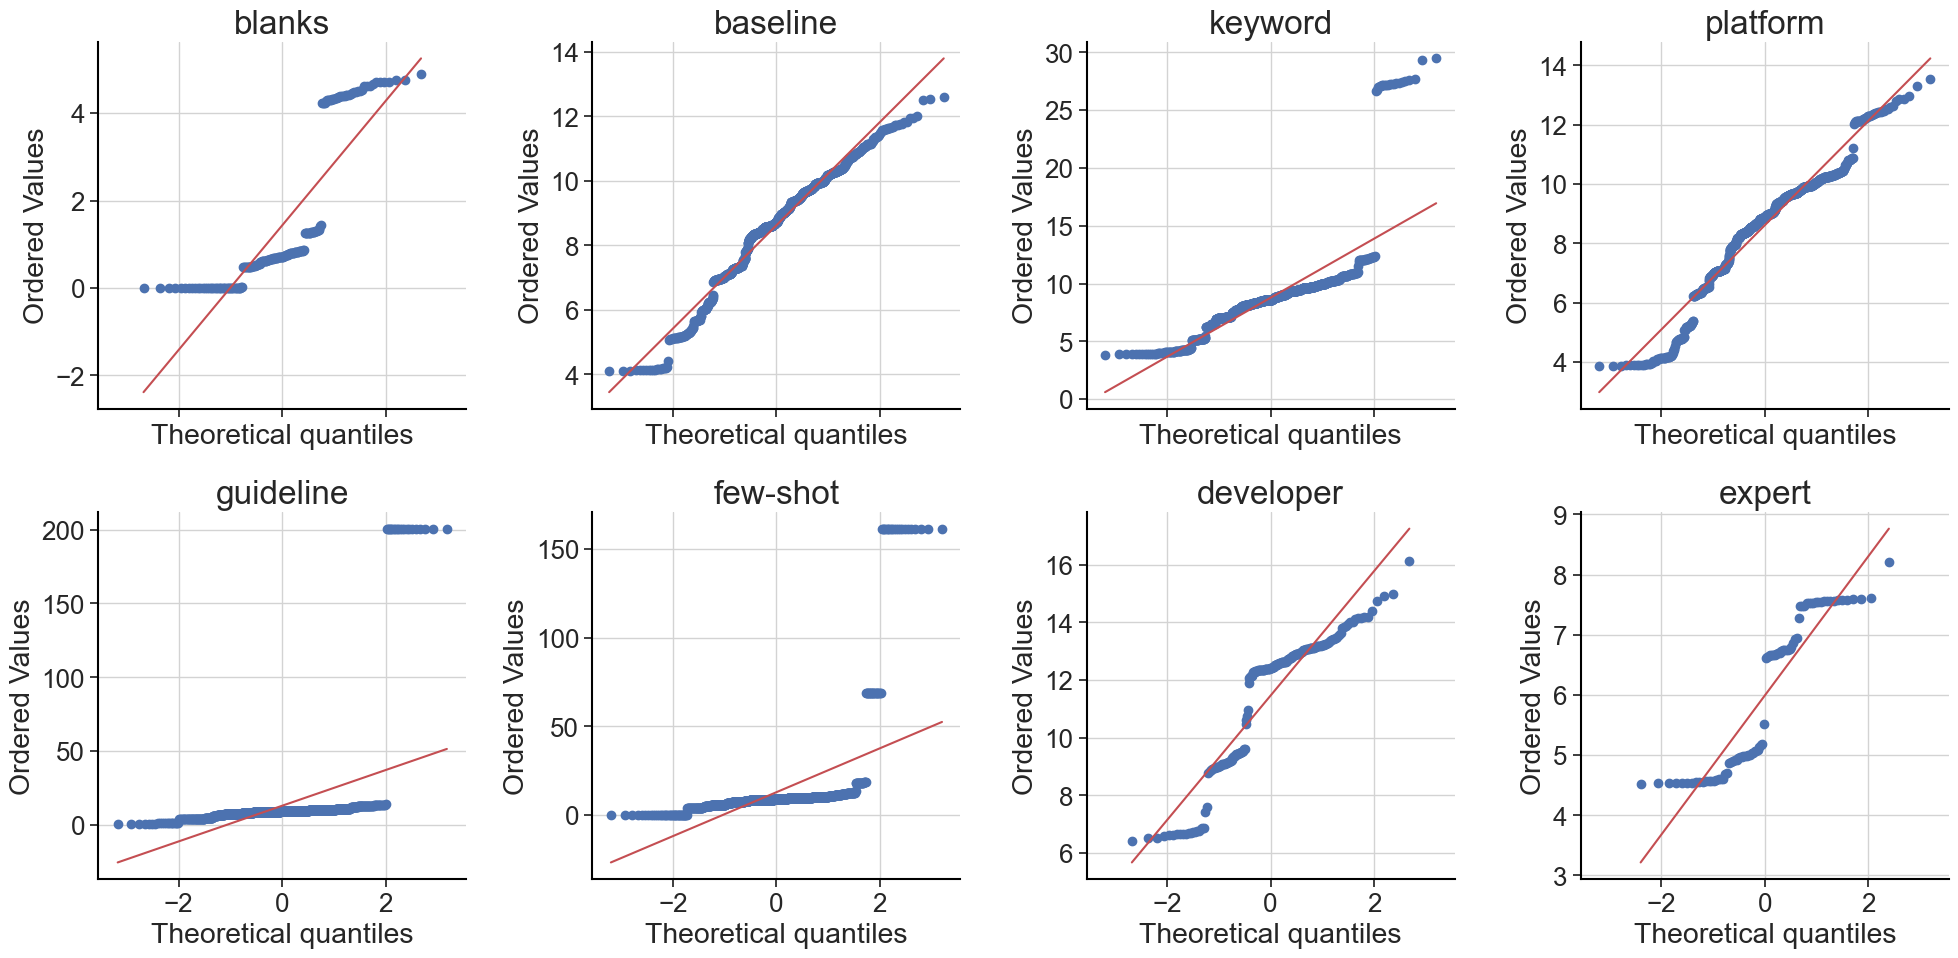

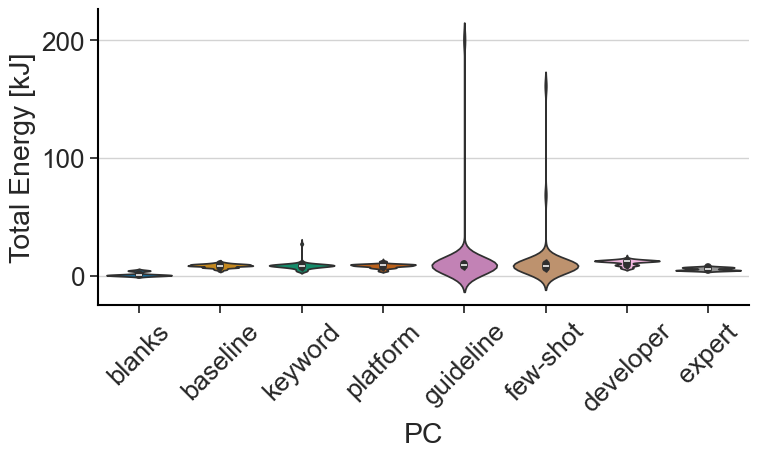

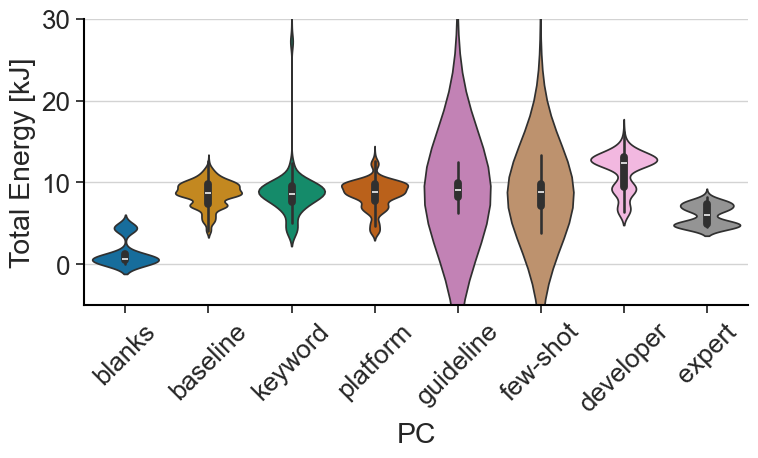

In [35]:
import scipy.stats as stats
import pylab as py

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10), sharey=False, sharex=True)

for id, experiment in enumerate(experiments):
	data_group = plotter[plotter['experiment'] == experiment]['Total Energy [kJ]']
	if experiment in ['blanks', 'developer', 'expert']:
		data_group = plotter[(plotter['experiment'] == experiment) & (plotter['llm'] == 'chatgpt')]['Total Energy [kJ]']
	
	res = scipy.stats.shapiro(data_group)
	print(experiment)
	print(f'Stat: {res.statistic}, P-value: {res.pvalue}')
	stats.probplot(data_group, dist='norm', plot=axs[id//4][id%4])
	axs[id//4][id%4].set_title(f'{experiment}', fontsize=24)
	print()
plt.tight_layout()
plt.savefig(f'./figures/{device}_QQ_plots.pdf', format='pdf')

plt.show()


fig, ax = plt.subplots(1, 1, figsize=(8, 5))
# sns.boxplot(x='experiment', y='Total Energy [kJ]', data=plotter, order=experiments, \
						# showmeans=True, meanprops=custom_mean, flierprops=custom_outliers, \
						# palette="colorblind", ax=ax)
sns.violinplot(x='experiment', y='Total Energy [kJ]', data=plotter, ax=ax, palette="colorblind", order=experiments)
ax.tick_params(axis='x', labelrotation=45)
plt.xlabel(f'PC')
plt.tight_layout()
plt.savefig(f'./figures/{device}_exploration.pdf', format='pdf')

plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
# sns.boxplot(x='experiment', y='Total Energy [kJ]', data=plotter, order=experiments, \
						# showmeans=True, meanprops=custom_mean, flierprops=custom_outliers, \
						# palette="colorblind", ax=ax)
sns.violinplot(x='experiment', y='Total Energy [kJ]', data=plotter, ax=ax, palette="colorblind", order=experiments)
ax.tick_params(axis='x', labelrotation=45)
ax.set_ylim(-5, 30)
plt.xlabel(f'PC')
plt.tight_layout()
# plt.savefig(f'./figures/{device}_exploration.pdf', format='pdf')

plt.show()

### RQ1

In [36]:
group_1 = plotter[(plotter['experiment'] == 'developer') & (plotter['llm'] == 'chatgpt')]['Total Energy [kJ]']
group_2 = plotter[plotter['experiment'] == 'baseline']['Total Energy [kJ]']

# A positive value means the first group has higher ranks, while a negative value suggests the opposite.
print(cliffs_delta(group_1, group_2))

(0.6430297770685778, 'large')


### RQ2

In [37]:
group_1 = plotter[plotter['experiment'] == 'keyword']['Total Energy [kJ]']
group_2 = plotter[plotter['experiment'] == 'guideline']['Total Energy [kJ]']
group_3 = plotter[plotter['experiment'] == 'platform']['Total Energy [kJ]']
group_4 = plotter[plotter['experiment'] == 'few-shot']['Total Energy [kJ]']
group_5 = plotter[plotter['experiment'] == 'baseline']['Total Energy [kJ]']


# A positive value means the first group has higher ranks, while a negative value suggests the opposite.
print('baseline vs. keyword:', cliffs_delta(group_5, group_1)) 
print('baseline vs. guideline:', cliffs_delta(group_5, group_2)) 
print('baseline vs. platform:', cliffs_delta(group_5, group_3)) 
print('baseline vs. few-shot:', cliffs_delta(group_5, group_4)) 
print('keyword vs. guideline:', cliffs_delta(group_1, group_2)) 
print('keyword vs. platform:', cliffs_delta(group_1, group_3)) 
print('keyword vs. few-shot:', cliffs_delta(group_1, group_4)) 
print('guideline vs. platform:', cliffs_delta(group_2, group_3)) 
print('guideline vs. few-shot:', cliffs_delta(group_2, group_4)) 
print('platform vs. few-shot:', cliffs_delta(group_3, group_4)) 

baseline vs. keyword: (0.05928585425939923, 'negligible')
baseline vs. guideline: (-0.08918563310097702, 'negligible')
baseline vs. platform: (-0.0041799641667366536, 'negligible')
baseline vs. few-shot: (-0.0015327118501721677, 'negligible')
keyword vs. guideline: (-0.1432896615436298, 'negligible')
keyword vs. platform: (-0.06581868858654573, 'negligible')
keyword vs. few-shot: (-0.057602670697908795, 'negligible')
guideline vs. platform: (0.08086629713613841, 'negligible')
guideline vs. few-shot: (0.07712899974804736, 'negligible')
platform vs. few-shot: (0.004883550642479214, 'negligible')


In [38]:
generated_names = ['baseline', 'keyword', 'platform', 'guideline', 'few-shot']
llm_ranking = plotter[plotter['experiment'].isin(generated_names)]

for name in generated_names:
	print(name, llm_ranking[llm_ranking['experiment'] == name].groupby(['llm'])['Total Energy [kJ]'].mean().reset_index().sort_values(by='Total Energy [kJ]'))
	print()

print('overall', llm_ranking.groupby(['llm'])['Total Energy [kJ]'].mean().reset_index().sort_values(by='Total Energy [kJ]'))


baseline                     llm  Total Energy [kJ]
1       code-millenials           7.889039
4  speechless-codellama           8.301723
3                 gpt-4           8.732000
2        deepseek-coder           8.840879
0               chatgpt           8.853528
5           wizardcoder           9.101333

keyword                     llm  Total Energy [kJ]
1       code-millenials           7.833699
2        deepseek-coder           8.117903
4  speechless-codellama           8.413052
3                 gpt-4           8.656326
0               chatgpt           9.324262
5           wizardcoder          10.826463

platform                     llm  Total Energy [kJ]
5           wizardcoder           7.590879
1       code-millenials           8.053929
2        deepseek-coder           8.372928
4  speechless-codellama           8.584950
3                 gpt-4           8.990685
0               chatgpt           9.560760

guideline                     llm  Total Energy [kJ]
5           wiz

### RQ3

In [39]:
group_7 = plotter[(plotter['experiment'] == 'expert') & (plotter['llm'] == 'chatgpt')]['Total Energy [kJ]']
group_all = plotter[(~plotter['experiment'].isin(['developer', 'expert'])) & (plotter['code'].isin([4, 61, 63, 90]))]
group_all = pd.concat([group_all, plotter[(plotter['experiment'] == 'developer') & (plotter['llm'] == 'chatgpt')]])
group_all = group_all['Total Energy [kJ]']


group_1 = plotter[(plotter['experiment'] == 'keyword') & (plotter['code'].isin([4, 61, 63, 90]))]['Total Energy [kJ]']
group_2 = plotter[(plotter['experiment'] == 'guideline') & (plotter['code'].isin([4, 61, 63, 90]))]['Total Energy [kJ]']
group_3 = plotter[(plotter['experiment'] == 'platform') & (plotter['code'].isin([4, 61, 63, 90]))]['Total Energy [kJ]']
group_4 = plotter[(plotter['experiment'] == 'few-shot') & (plotter['code'].isin([4, 61, 63, 90]))]['Total Energy [kJ]']
group_5 = plotter[(plotter['experiment'] == 'baseline') & (plotter['code'].isin([4, 61, 63, 90]))]['Total Energy [kJ]']
group_6 = plotter[(plotter['experiment'] == 'developer') & (plotter['llm'] == 'chatgpt') & (plotter['code'].isin([4, 61, 63, 90]))]['Total Energy [kJ]']

# A positive value means the first group has higher ranks, while a negative value suggests the opposite.
print('expert vs. keyword:', cliffs_delta(group_7, group_1))
print('expert vs. guideline:', cliffs_delta(group_7, group_2))
print('expert vs. platform:', cliffs_delta(group_7, group_3))
print('expert vs. few-shot:', cliffs_delta(group_7, group_4))
print('expert vs. baseline:', cliffs_delta(group_7, group_5))
print('expert vs. developer:', cliffs_delta(group_7, group_6))

expert vs. keyword: (-0.4434652648938363, 'medium')
expert vs. guideline: (-0.4102518200262561, 'medium')
expert vs. platform: (-0.4293272864701436, 'medium')
expert vs. few-shot: (-0.37620127416045784, 'medium')
expert vs. baseline: (-0.5324074074074074, 'large')
expert vs. developer: (-0.8047052154195011, 'large')


# RPI

## Statistics

In [4]:
import scipy
import scipy.stats
import numpy as np
import pandas as pd
from cliffs_delta import cliffs_delta

device = 'RPI'
experiments = ['blanks', 'baseline', 'keyword', 'platform', 'guideline', 'few-shot', 'developer', 'expert']

data_df = pd.read_parquet(f'../{device}/data_df.parquet')
data_df = data_df.reset_index()
data_df = data_df.dropna()
data_df = data_df.drop(columns=['index'])
data_df['Total Energy [kJ]'] = data_df['TOTAL_ENERGY'] / 1000000.0
data_df = data_df.drop(data_df[(data_df['experiment'].isin(['blanks', 'developer', 'expert'])) & (data_df['llm'] != 'chatgpt')].index)
plotter = data_df.groupby(['device', 'experiment', 'llm', 'code', 'repetition'])['Total Energy [kJ]'].mean().reset_index()
plotter.to_parquet(f'../{device}/r_ready.parquet')


summary = plotter[['experiment', 'Total Energy [kJ]']].groupby(['experiment'])
print(summary.describe().reset_index().T.to_latex())
# print(summary.describe().to_latex())

\begin{tabular}{llllllllll}
\toprule
 &  & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 \\
\midrule
experiment &  & baseline & blanks & developer & expert & few-shot & guideline & keyword & platform \\
\cline{1-10}
\multirow[t]{8}{*}{Total Energy [kJ]} & count & 1134.000000 & 189.000000 & 187.000000 & 84.000000 & 923.000000 & 944.000000 & 987.000000 & 1008.000000 \\
 & mean & 0.453161 & 0.077938 & 0.441513 & 0.340141 & 0.453742 & 0.413093 & 0.441686 & 0.445248 \\
 & std & 0.064070 & 0.080405 & 0.067276 & 0.073168 & 0.098503 & 0.103736 & 0.078356 & 0.085859 \\
 & min & 0.266868 & 0.002424 & 0.149676 & 0.281699 & 0.194264 & 0.060372 & 0.238817 & 0.245013 \\
 & 25% & 0.409418 & 0.035633 & 0.386808 & 0.295407 & 0.395397 & 0.383961 & 0.401467 & 0.399619 \\
 & 50% & 0.460305 & 0.039963 & 0.434632 & 0.300509 & 0.444662 & 0.407399 & 0.444996 & 0.444545 \\
 & 75% & 0.492628 & 0.075800 & 0.494239 & 0.354956 & 0.498088 & 0.432509 & 0.489583 & 0.484723 \\
 & max & 0.688973 & 0.235397 & 0.590420 & 0.483198 & 0.83

In [5]:
summary_reset = summary.describe().reset_index()
summary_reset['coef_var'] = summary_reset['Total Energy [kJ]']['std'] / summary_reset['Total Energy [kJ]']['mean'] * 100.0
summary_reset['coef_var'] = summary_reset['coef_var'].round(3)
summary_reset

experiment Total Energy [kJ]                                          \
                         count      mean       std       min       25%   
0   baseline            1134.0  0.453161  0.064070  0.266868  0.409418   
1     blanks             189.0  0.077938  0.080405  0.002424  0.035633   
2  developer             187.0  0.441513  0.067276  0.149676  0.386808   
3     expert              84.0  0.340141  0.073168  0.281699  0.295407   
4   few-shot             923.0  0.453742  0.098503  0.194264  0.395397   
5  guideline             944.0  0.413093  0.103736  0.060372  0.383961   
6    keyword             987.0  0.441686  0.078356  0.238817  0.401467   
7   platform            1008.0  0.445248  0.085859  0.245013  0.399619   

                                coef_var  
        50%       75%       max           
0  0.460305  0.492628  0.688973   14.138  
1  0.039963  0.075800  0.235397  103.166  
2  0.434632  0.494239  0.590420   15.238  
3  0.300509  0.354956  0.483198   21.511  
4  0.444662  0.498088  0.831037   21.709  
5  0.407399  0.432509  0.771106   25.112  
6  0.444996  0.489583  0.756297   17.740  
7  0.444545  0.484723  0.752662   19.283

#### Percentages

In [6]:
# give me the differences between the groups means in percentages
for experiment in experiments:
	for experiment2 in experiments:
		if experiment == experiment2:
			continue
		group_1 = plotter[plotter['experiment'] == experiment]['Total Energy [kJ]']
		group_2 = plotter[plotter['experiment'] == experiment2]['Total Energy [kJ]']
		print(experiment, experiment2, (group_1.mean() - group_2.mean()) / group_2.mean(), (group_1.mean() - group_2.mean()) / group_2.mean() * 100.0, '%')
	print()

blanks baseline -0.828013039077118 -82.8013039077118 %
blanks keyword -0.8235447833050373 -82.35447833050374 %
blanks platform -0.8249563421903239 -82.49563421903238 %
blanks guideline -0.8113313134451029 -81.13313134451029 %
blanks few-shot -0.8282332941880647 -82.82332941880647 %
blanks developer -0.8234758400595037 -82.34758400595037 %
blanks expert -0.7708664398525183 -77.08664398525184 %

baseline blanks 4.814394269391119 481.4394269391119 %
baseline keyword 0.025980200755359402 2.59802007553594 %
baseline platform 0.01777284086184119 1.777284086184119 %
baseline guideline 0.09699412991834258 9.699412991834258 %
baseline few-shot -0.001280650054893383 -0.1280650054893383 %
baseline developer 0.026381063967103224 2.6381063967103224 %
baseline expert 0.3322728590467032 33.22728590467032 %

keyword blanks 4.6671603069049254 466.7160306904925 %
keyword baseline -0.02532232175263416 -2.5322321752634163 %
keyword platform -0.007999530485554877 -0.7999530485554877 %
keyword guideline 0.0

blanks
Stat: 0.7462322973476192, P-value: 9.827031720061072e-17

baseline
Stat: 0.9799551375375006, P-value: 2.0563202568788287e-11

keyword
Stat: 0.9476229843415167, P-value: 3.143276934953619e-18

platform
Stat: 0.9358735403329884, P-value: 2.0865968143249473e-20

guideline
Stat: 0.8394864707406497, P-value: 8.419410099853404e-30

few-shot
Stat: 0.9467340962966808, P-value: 9.952169612720432e-18

developer
Stat: 0.9578304125257125, P-value: 2.2207000136683348e-05

expert
Stat: 0.6425027590925181, P-value: 5.42139875697327e-13



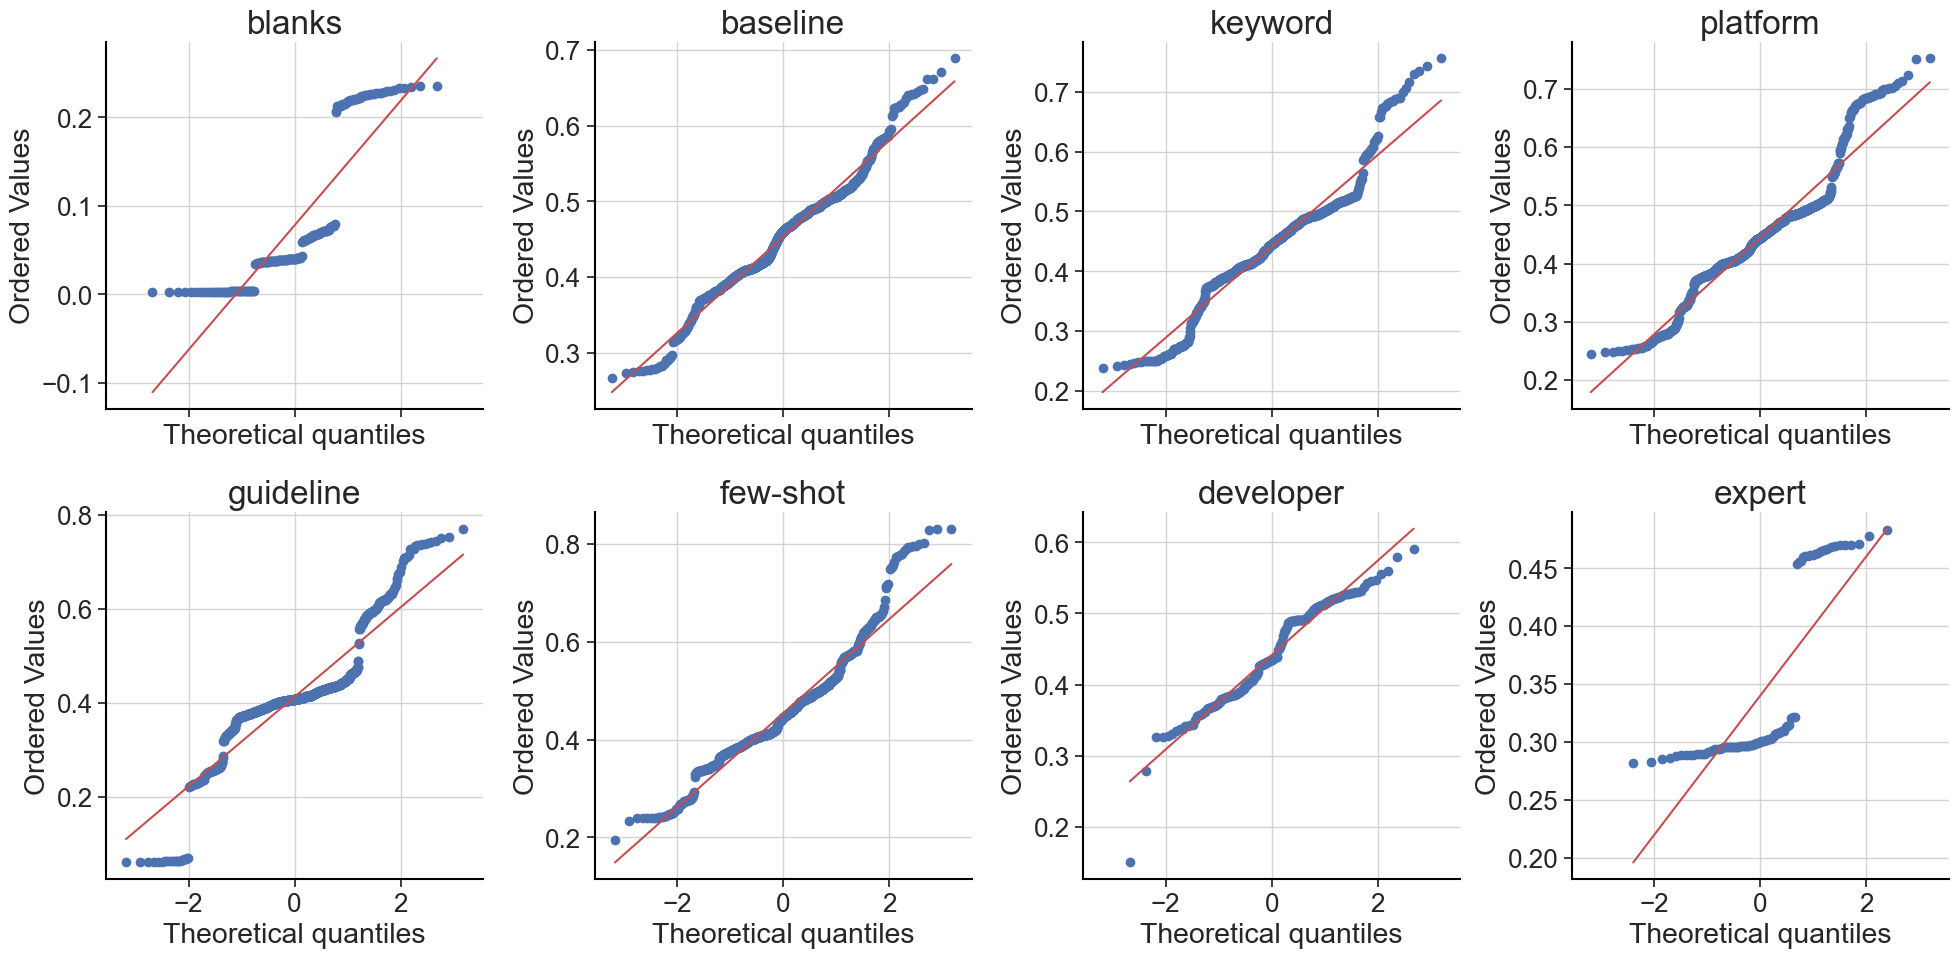

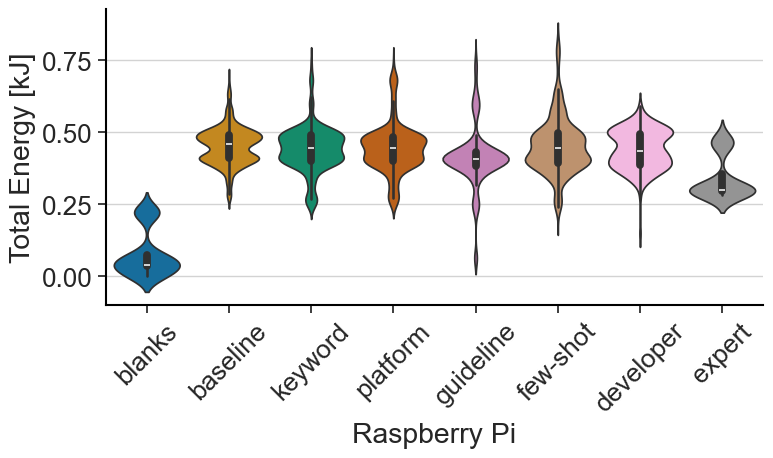

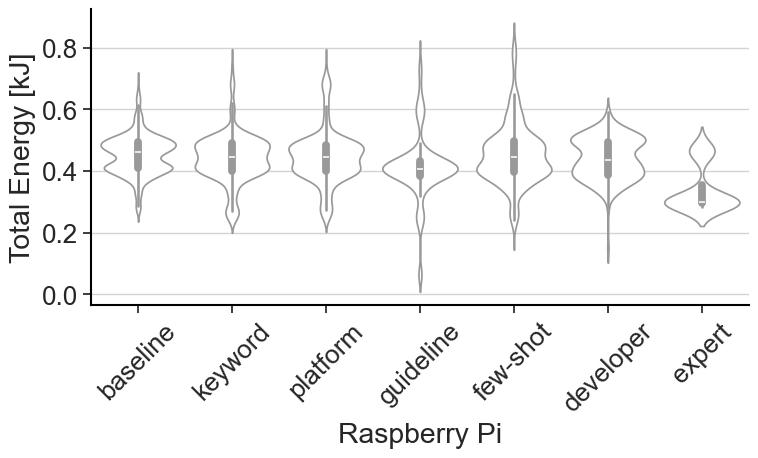

In [9]:
import scipy.stats as stats
import pylab as py

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10), sharey=False, sharex=True)

for id, experiment in enumerate(experiments):
	data_group = plotter[plotter['experiment'] == experiment]['Total Energy [kJ]']
	if experiment in ['blanks', 'developer', 'expert']:
		data_group = plotter[(plotter['experiment'] == experiment) & (plotter['llm'] == 'chatgpt')]['Total Energy [kJ]']
	
	res = scipy.stats.shapiro(data_group)
	print(experiment)
	print(f'Stat: {res.statistic}, P-value: {res.pvalue}')
	stats.probplot(data_group, dist='norm', plot=axs[id//4][id%4])
	axs[id//4][id%4].set_title(f'{experiment}', fontsize=24)
	print()
plt.tight_layout()
plt.savefig(f'./figures/{device}_QQ_plots.pdf', format='pdf')

plt.show()


fig, ax = plt.subplots(1, 1, figsize=(8, 5))
# sns.boxplot(x='experiment', y='Total Energy [kJ]', data=plotter, order=experiments, \
						# showmeans=True, meanprops=custom_mean, flierprops=custom_outliers, \
						# palette="colorblind", ax=ax)
sns.violinplot(x='experiment', y='Total Energy [kJ]', data=plotter, ax=ax, palette="colorblind", order=experiments)
ax.tick_params(axis='x', labelrotation=45)
plt.xlabel(f'Raspberry Pi')
plt.tight_layout()
plt.savefig(f'./figures/{device}_exploration.pdf', format='pdf')

plt.show()



### RQ1

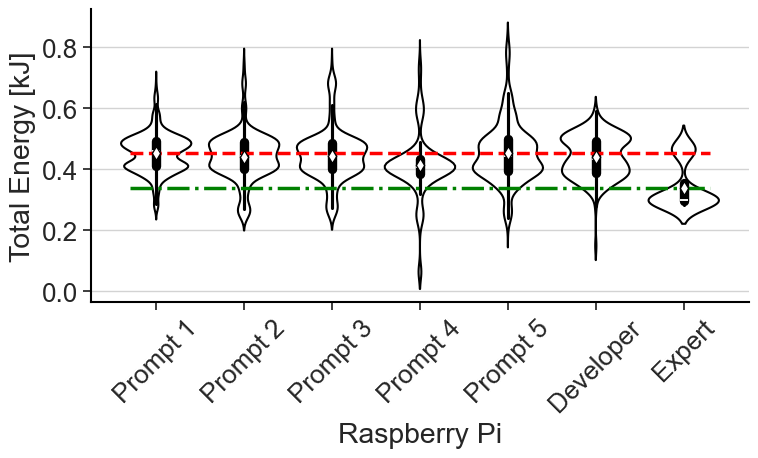

In [90]:
PROPS = {
    'color': 'white',
    'linecolor': 'black',
    'fill': False,
    'linewidth': 1.5
}

# width=width,
# dodge=dodge,
# gap=gap,
# split=split,
# color=color,
# fill=fill,
# linecolor=linecolor,
# linewidth=linewidth,
# inner=inner,
# density_norm=density_norm,
# common_norm=common_norm,
# kde_kws=kde_kws,
# inner_kws=inner_kws,
# plot_kws=kwargs,

Means = sorted.groupby('experiment')['Total Energy [kJ]'].mean()
Means = Means[experiments[1:]]

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
# sns.boxplot(x='experiment', y='Total Energy [kJ]', data=plotter, order=experiments, \
						# showmeans=True, meanprops=custom_mean, flierprops=custom_outliers, \
						# palette="colorblind", ax=ax)
sns.violinplot(x='experiment', y='Total Energy [kJ]', data=plotter[plotter['experiment'] != 'blanks'], ax=ax, palette=['black'], order=experiments[1:], **PROPS)
plt.scatter(x=range(len(Means)), y=Means, color='white', marker='d', edgecolor='black', s=50, zorder=3, label='Mean')

ax.tick_params(axis='x', labelrotation=45)
ax.set_xticklabels(['Prompt 1', 'Prompt 2', 'Prompt 3', 'Prompt 4', 'Prompt 5',  'Developer', 'Expert'])

l1 = ax.hlines(0.34, -0.3, 6.3, color='green', linestyle='-.', linewidth=2.5)
# ax.text(-0.3, 0.8, 'Most efficient mean = 0.34 kJ', fontsize=15, color='green')

l2 = ax.hlines(0.453, -0.3, 6.3, color='red', linestyle='--', linewidth=2.5)
# ax.text(-0.3, 0.453, 'Least efficient mean = 0.44 kJ', fontsize=15, color='red')

# ax.legend([l1, l2], ['Most efficient mean = 0.34kJ', 'Least efficient mean = 0.45 kJ'], loc='upper left')

plt.xlabel(f'Raspberry Pi')
plt.tight_layout()
plt.savefig(f'./figures/first_fig.pdf', format='pdf')

plt.show()

In [52]:
group_1 = plotter[(plotter['experiment'] == 'developer') & (plotter['llm'] == 'chatgpt')]['Total Energy [kJ]']
group_2 = plotter[plotter['experiment'] == 'baseline']['Total Energy [kJ]']

# A positive value means the first group has higher ranks, while a negative value suggests the opposite.
print(cliffs_delta(group_1, group_2))

(-0.07459280008299617, 'negligible')


### RQ2

In [53]:
group_1 = plotter[plotter['experiment'] == 'keyword']['Total Energy [kJ]']
group_2 = plotter[plotter['experiment'] == 'guideline']['Total Energy [kJ]']
group_3 = plotter[plotter['experiment'] == 'platform']['Total Energy [kJ]']
group_4 = plotter[plotter['experiment'] == 'few-shot']['Total Energy [kJ]']
group_5 = plotter[plotter['experiment'] == 'baseline']['Total Energy [kJ]']


# A positive value means the first group has higher ranks, while a negative value suggests the opposite.
print('baseline vs. keyword:', cliffs_delta(group_5, group_1)) 
print('baseline vs. guideline:', cliffs_delta(group_5, group_2)) 
print('baseline vs. platform:', cliffs_delta(group_5, group_3)) 
print('baseline vs. few-shot:', cliffs_delta(group_5, group_4)) 
print('keyword vs. guideline:', cliffs_delta(group_1, group_2)) 
print('keyword vs. platform:', cliffs_delta(group_1, group_3)) 
print('keyword vs. few-shot:', cliffs_delta(group_1, group_4)) 
print('guideline vs. platform:', cliffs_delta(group_2, group_3)) 
print('guideline vs. few-shot:', cliffs_delta(group_2, group_4)) 
print('platform vs. few-shot:', cliffs_delta(group_3, group_4)) 

baseline vs. keyword: (0.08964510416722507, 'negligible')
baseline vs. guideline: (0.37554740979882223, 'medium')
baseline vs. platform: (0.10775874135662496, 'negligible')
baseline vs. few-shot: (0.06219463026974764, 'negligible')
keyword vs. guideline: (0.29703089313619424, 'small')
keyword vs. platform: (0.016731397050545986, 'negligible')
keyword vs. few-shot: (-0.018920945202036, 'negligible')
guideline vs. platform: (-0.2807728847188593, 'small')
guideline vs. few-shot: (-0.2557361771673063, 'small')
platform vs. few-shot: (-0.030634662676916197, 'negligible')


In [54]:
generated_names = ['baseline', 'keyword', 'platform', 'guideline', 'few-shot']
llm_ranking = plotter[plotter['experiment'].isin(generated_names)]

for name in generated_names:
  print(name, llm_ranking[llm_ranking['experiment'] == name].groupby(['llm'])['Total Energy [kJ]'].mean().reset_index().sort_values(by='Total Energy [kJ]'))
  print()

print('overall', llm_ranking.groupby(['llm'])['Total Energy [kJ]'].mean().reset_index().sort_values(by='Total Energy [kJ]'))


baseline                     llm  Total Energy [kJ]
1       code-millenials           0.414780
2        deepseek-coder           0.440224
4  speechless-codellama           0.445965
5           wizardcoder           0.452244
3                 gpt-4           0.477363
0               chatgpt           0.488391

keyword                     llm  Total Energy [kJ]
5           wizardcoder           0.376533
2        deepseek-coder           0.408326
1       code-millenials           0.412405
4  speechless-codellama           0.440630
3                 gpt-4           0.473308
0               chatgpt           0.506016

platform                     llm  Total Energy [kJ]
5           wizardcoder           0.359332
1       code-millenials           0.412374
2        deepseek-coder           0.430768
4  speechless-codellama           0.441639
3                 gpt-4           0.488209
0               chatgpt           0.498969

guideline                     llm  Total Energy [kJ]
4  speechless-c

### RQ3

In [55]:
group_7 = plotter[(plotter['experiment'] == 'expert') & (plotter['llm'] == 'chatgpt')]['Total Energy [kJ]']
group_all = plotter[(~plotter['experiment'].isin(['developer', 'expert'])) & (plotter['code'].isin([4, 61, 63, 90]))]
group_all = pd.concat([group_all, plotter[(plotter['experiment'] == 'developer') & (plotter['llm'] == 'chatgpt')]])
group_all = group_all['Total Energy [kJ]']


group_1 = plotter[(plotter['experiment'] == 'keyword') & (plotter['code'].isin([4, 61, 63, 90]))]['Total Energy [kJ]']
group_2 = plotter[(plotter['experiment'] == 'guideline') & (plotter['code'].isin([4, 61, 63, 90]))]['Total Energy [kJ]']
group_3 = plotter[(plotter['experiment'] == 'platform') & (plotter['code'].isin([4, 61, 63, 90]))]['Total Energy [kJ]']
group_4 = plotter[(plotter['experiment'] == 'few-shot') & (plotter['code'].isin([4, 61, 63, 90]))]['Total Energy [kJ]']
group_5 = plotter[(plotter['experiment'] == 'baseline') & (plotter['code'].isin([4, 61, 63, 90]))]['Total Energy [kJ]']
group_6 = plotter[(plotter['experiment'] == 'developer') & (plotter['llm'] == 'chatgpt') & (plotter['code'].isin([4, 61, 63, 90]))]['Total Energy [kJ]']

# A positive value means the first group has higher ranks, while a negative value suggests the opposite.
print('expert vs. keyword:', cliffs_delta(group_7, group_1))
print('expert vs. guideline:', cliffs_delta(group_7, group_2))
print('expert vs. platform:', cliffs_delta(group_7, group_3))
print('expert vs. few-shot:', cliffs_delta(group_7, group_4))
print('expert vs. baseline:', cliffs_delta(group_7, group_5))
print('expert vs. developer:', cliffs_delta(group_7, group_6))

expert vs. keyword: (-0.4725191663967174, 'medium')
expert vs. guideline: (-0.28237259816207183, 'small')
expert vs. platform: (-0.46863189720332576, 'medium')
expert vs. few-shot: (-0.5291935869825317, 'large')
expert vs. baseline: (-0.6913265306122449, 'large')
expert vs. developer: (-0.6103368176538908, 'large')
